In [1]:
import os
from tvb.simulator.lab import *
import numpy as np
import seaborn
import matplotlib.pyplot as plt
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
file = '/Users/yilewang/workspaces/data4project/lateralization/connectome/zip/AD/0306A.zip'

connectivity.speed = np.array([10.])
sim = simulator.Simulator(
    model=ReducedSetHindmarshRose(K21=np.array([0.015])), 
    connectivity=connectivity.Connectivity.from_file(file),                      
    coupling=coupling.Linear(a=np.array([0.02])),
    simulation_length=1e3*416,
    integrator=integrators.HeunStochastic(dt=0.01220703125, noise=noise.Additive(nsig=np.array([1.0]), ntau=0.0,
                                                                                random_stream=np.random.RandomState(seed=42))),
    monitors=(
    monitors.TemporalAverage(period=1.),
    monitors.Bold(hrf_kernel = equations.Gamma(), period=2000.),
    monitors.ProgressLogger(period=1e2))
).configure()
sim.configure()

2023-09-13 12:18:38,510 - WARNING - tvb.basic.readers - File 'average_orientations' not found in ZIP.
2023-09-13 12:18:38,511 - WARNING - tvb.basic.readers - File 'cortical' not found in ZIP.
2023-09-13 12:18:38,511 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2023-09-13 12:18:38,511 - WARNING - tvb.basic.readers - File 'areas' not found in ZIP.


In [3]:
(tavg_time, tavg_data), (raw_time, raw_data),_ = sim.run()

2023-09-13 12:18:38,557 - INFO - tvb.simulator.monitors - step 1 time 0.0000 s
2023-09-13 12:18:39,660 - INFO - tvb.simulator.monitors - step 8193 time 0.1000 s
2023-09-13 12:18:40,774 - INFO - tvb.simulator.monitors - step 16385 time 0.2000 s
2023-09-13 12:18:41,888 - INFO - tvb.simulator.monitors - step 24577 time 0.3000 s
2023-09-13 12:18:42,982 - INFO - tvb.simulator.monitors - step 32769 time 0.4000 s
2023-09-13 12:18:44,071 - INFO - tvb.simulator.monitors - step 40961 time 0.5000 s
2023-09-13 12:18:45,158 - INFO - tvb.simulator.monitors - step 49153 time 0.6000 s
2023-09-13 12:18:46,244 - INFO - tvb.simulator.monitors - step 57345 time 0.7000 s
2023-09-13 12:18:47,331 - INFO - tvb.simulator.monitors - step 65537 time 0.8000 s
2023-09-13 12:18:48,414 - INFO - tvb.simulator.monitors - step 73729 time 0.9000 s
2023-09-13 12:18:49,502 - INFO - tvb.simulator.monitors - step 81921 time 1.0000 s
2023-09-13 12:18:50,590 - INFO - tvb.simulator.monitors - step 90113 time 1.1000 s
2023-09-1

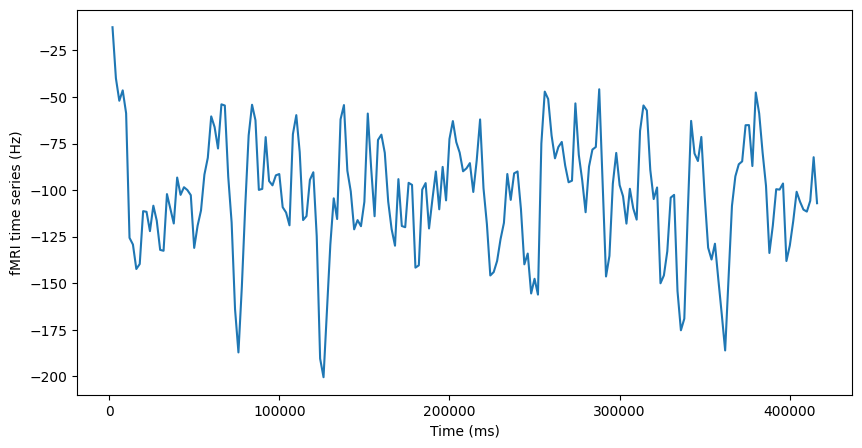

In [6]:
# visualize the results
plt.figure(figsize=(10, 5))
plt.plot(raw_time, raw_data[:, 0, 5, 0])

plt.xlabel('Time (ms)')
plt.ylabel('fMRI time series (Hz)')

plt.show()